# Importing Libraries

In [1]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
#Training Models
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score
#Neural Network
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("spam.csv", encoding="latin-1") 
data = data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1) #Drop NAn Values
data = data.rename(columns={'v1':'label', 'v2':'text'}) #Renaming columns to label and text
tags = data["label"] #Set label varable to tags
texts = data["text"] #Set text varable to tags
data['classification'] = data['label'].map({'ham':0,'spam':1}) #Adding binary values to classify ham or spam
data.head()

,label,text,classification
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


### To do: develop an accurate simple neural network model for spam classification (no LSTM, CNN, etc.)

# Data Analysis

In [3]:
data.info() #Checking data info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   label           5572 non-null   object
 1   text            5572 non-null   object
 2   classification  5572 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 130.7+ KB


In [4]:
data.isnull().sum() #Checking for NaN values

label             0
text              0
classification    0
dtype: int64

In [5]:
data.nunique() #Identifying uniques values

label                2
text              5169
classification       2
dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

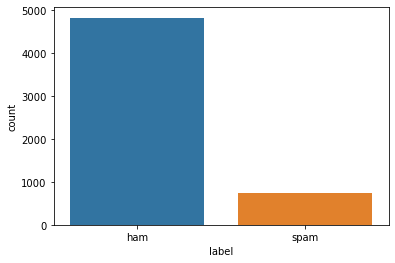

In [6]:
sns.countplot('label', data=data) #Plotting data on values for spam and ham

# Preparing Data

In [7]:
#Identifying legth of mean words
mean_words_length=round(sum([len(i.split()) for i in data['text']])/len(data['text']))
print(mean_words_length)

15


In [8]:
#Identifying total no. of unique words in corpus
s = set()
for sent in data['text']:
  for word in sent.split():
    s.add(word)
total_words_length=len(s)
print(total_words_length)

15585


In [9]:
#Splitting spam, ham data for training and testing 
X = np.asanyarray(texts) #all text data
y = np.asanyarray(data['classification']) #classification of spam or ham data
new_data = pd.DataFrame({'text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
    new_data['text'], new_data['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4457,), (4457,), (1115,), (1115,))

In [10]:
# Choosing a model
tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)


#Classification model using naive beyes MNB
model = MultinomialNB()
model.fit(X_train_vec,y_train) #Training

MultinomialNB()

In [11]:
#Baseline model Evaluation
nb_accuracy = accuracy_score(y_test, model.predict(X_test_vec))
print(nb_accuracy)        
print(classification_report(y_test, model.predict(X_test_vec)))

0.9623318385650225
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



In [12]:
#Setting Parameters of word values
token = total_words_length
outputlen = mean_words_length

text_vec = TextVectorization(
    max_tokens = token,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=outputlen
)
text_vec.adapt(X_train)

# Neural Network Building

In [13]:
#Parameter Tuning
embedding_layer = layers.Embedding(
    input_dim=token, #size of vocabulary
    output_dim=128, #the dimension of the embedding layer 
    embeddings_initializer='uniform',
    input_length=outputlen #legnth of sequence
)

In [14]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1994880   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128  

In [15]:
#Compile (optimizers,lossand metrics parameters)
model_1.compile(optimizer=keras.optimizers.Adam(),
               loss=keras.losses.BinaryCrossentropy(label_smoothing=0.5),
               metrics=['accuracy'])

In [16]:
history_1 = model_1.fit(X_train,
           y_train,
           epochs=5,
           validation_data=(X_test, y_test),
           validation_steps=int(0.2 * len(X_test)))

Epoch 1/5
140/140 [==============================] - 6s 37ms/step - loss: 0.6041 - accuracy: 0.9159 - val_loss: 0.5766 - val_accuracy: 0.9740
Epoch 2/5
140/140 [==============================] - 4s 31ms/step - loss: 0.5701 - accuracy: 0.9865 - val_loss: 0.5734 - val_accuracy: 0.9803
Epoch 3/5
140/140 [==============================] - 4s 31ms/step - loss: 0.5658 - accuracy: 0.9953 - val_loss: 0.5725 - val_accuracy: 0.9830
Epoch 4/5
140/140 [==============================] - 5s 36ms/step - loss: 0.5642 - accuracy: 0.9982 - val_loss: 0.5726 - val_accuracy: 0.9830
Epoch 5/5
140/140 [==============================] - 4s 31ms/step - loss: 0.5636 - accuracy: 0.9989 - val_loss: 0.5725 - val_accuracy: 0.9839


# Prediction

In [17]:
#Testing accuracy and testing loss values
loss, accuracy = model_1.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy {:.4f}".format(accuracy))
loss, accuracy = model_1.evaluate(X_test, y_test, verbose=False)
print("Testing Loss {:.4f}".format(loss))

Testing Accuracy 0.9839
Testing Loss 0.5725


In [18]:
data.to_csv("output_spam.csv")